# Society of Mind

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import yaml


In [2]:
from community.data.datasets import DoubleMNIST
from community.common.init import init_community, init_optimizers
from community.common.training import train_community

In [3]:
import warnings
#warnings.filterwarnings('ignore')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

root = '../data/'

dataset1 = datasets.MNIST(root, train=True, download=False,
                   transform=transform)
dataset2 = datasets.MNIST(root, train=False,
                   transform=transform)

double_dataset1 = DoubleMNIST(root, fix_asym=False)
double_dataset2 = DoubleMNIST(root, train=False, fix_asym=False)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
train_loader.n_classes, test_loader.n_classes = 10, 10

double_train_loader = torch.utils.data.DataLoader(double_dataset1,**train_kwargs)
double_test_loader = torch.utils.data.DataLoader(double_dataset2, **test_kwargs)
double_train_loader.single_loader, double_test_loader.single_loader = train_loader, test_loader
double_train_loader.n_classes, double_test_loader.n_classes = 100, 100

sub_train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset1, np.arange(batch_size)),**train_kwargs)
sub_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset2, np.arange(batch_size)),**train_kwargs)

dtype = torch.float32


## Standard Community

### Community Initialization

In [6]:
agents_params_dict = {'n_agents' : 2,
                         'n_in' : 784,
                         'n_ins' : None,
                         'n_hid' : 100,
                         'n_layer' : 1,
                         'n_out' : 10,
                         'train_in_out': (True, False),
                         'use_readout': True,
                         'cell_type': str(nn.RNN),
                         'use_bottleneck': False,
                         'dropout': 0}

p_con = 1e-3

community = init_community(agents_params_dict, p_con, device=device)
community.nb_connections

{'01': tensor(10), '10': tensor(10)}

In [7]:
params = lr, gamma = 1e-3, 0.95
params_dict = {'lr' : lr, 'gamma' : gamma}

deepR_params = l1, gdnoise, lr, gamma, cooling = 1e-5, 1e-3, 1e-3, 0.95, 0.95
deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma, 'cooling' : cooling}


optimizers, schedulers = init_optimizers(community, params_dict, deepR_params_dict)

In [8]:
n

NameError: name 'n' is not defined

### Training

In [15]:
training_dict = {
    'n_epochs' : 2, 
    'task' : 'parity_digits',
    'global_rewire' : True, 
    'check_gradients' : False, 
    'reg_factor' : 0.,
    'train_connections' : True,
    'global_rewire' : True,
    'decision_params' : ('last', 'max'),
    'early_stop' : True ,
    'deepR_params_dict' : deepR_params_dict,
}

#pyaml.save(training_dict, '../community/common/default_train_dict.yml')


train_out = train_community(community, double_train_loader, double_test_loader, optimizers, 
                            schedulers=schedulers, config=training_dict, device=device)
                            
results = train_out

Train Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:

train_losses, train_accs, test_losses, test_accs, deciding_agents, best_state = list(results.values())

In [20]:
deciding_agents.shape

(1, 39, 256)

### Results

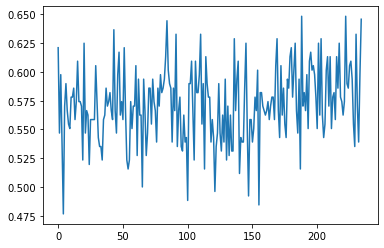

In [27]:
plt.plot(train_accs)
m = 1
epochs_slices = np.arange(0, len(train_accs)+1, m*len(train_loader))
max_per_epoch = [np.max(train_accs[epochs_slices[e]:epochs_slices[e+1]]) for e in range(len(epochs_slices)-1)]
#max_per_epoch.append(np.max(train_accs[epochs_slices[-1]:]))
plt.plot(epochs_slices[1:], max_per_epoch)
